**Problem Statement: Human Activity Recognition using LSTM+CNN.**

(a) Dataset : UCI HARLinks to an external site.

(b) Human Activity Recognition is the process of identifying the human activity from sensor data. It uses both Natural Language Processing and Computer Vision to recognize the activities.

In [1]:
'''
Import Libraries

'''
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import backend
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
import tensorflow as tf
from zipfile import ZipFile
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping
tf.keras.backend.clear_session()

In [2]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [3]:
'''
Function to Download Zip file from UCI Archieves
Fundtion to load data
Fundtion to load Signals Data
Function to Transform and Reshape Data
'''

def download_file(url, save_folder):
    local_filename = url.split('/')[-1]  
    if os.path.isfile(os.path.join(save_folder, local_filename)): return os.path.join(save_folder, local_filename)
    r = requests.get(url, stream=True)
    with open(os.path.join(save_folder, local_filename), 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    return os.path.join(save_folder, local_filename)

def count_classes(y):
    return len(set([tuple(category) for category in y]))

def read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            read_csv(filename).to_numpy()
        ) 
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
        filename = f'UCI HAR Dataset/{subset}/y_{subset}.txt'
        y = read_csv(filename)[0]
        return pd.get_dummies(y).to_numpy()
    
def load_data():
    X_train_2c, X_val_2c = load_signals('train'), load_signals('test')
    Y_train_2c, Y_val_2c = load_y('train'), load_y('test')  
    Scale = fit(X_train_2c)
    X_train_2c = transform(X_train_2c, Scale)
    X_val_2c = transform(X_val_2c, Scale)
    
    return X_train_2c, Y_train_2c, X_val_2c, Y_val_2c 

def transform(X, scale):
    temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
    temp_X1 = scale.transform(temp_X1)
    return temp_X1.reshape(X.shape)

def fit(X):
    remove = int(X.shape[1] / 2)
    temp_X = X[:, -remove:, :]
    temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
    scale = StandardScaler()
    scale.fit(temp_X)
    return scale

In [4]:
'''
Data URL
'''

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip'

In [5]:
'''
Download the Data File from URL
'''

humanactivity = download_file(data_url, os.getcwd())

In [6]:
'''
Print Data download directory in local file system
'''

print(humanactivity)

/content/UCI HAR Dataset.zip


In [7]:
'''
Zip file name and Details
'''

zipfilename = "{}/UCI HAR Dataset.zip".format(os.getcwd())

In [8]:
'''
Un-Zip the input Zip file
'''

with ZipFile(zipfilename, 'r') as zObject:
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path=os.getcwd())

In [9]:
'''
Training Data File Directory
'''

train_data_directory = "{}/UCI HAR Dataset/train".format(os.getcwd())

In [10]:
'''
Test Data File Directory
'''

test_data_directory = "{}/UCI HAR Dataset/test".format(os.getcwd())

In [11]:
'''
Train Data File name for Training Features
'''

train_X_file = "{}/X_train.txt".format(train_data_directory)

In [12]:
'''
Train Data File name for Label
'''

train_y_file = "{}/y_train.txt".format(train_data_directory)

In [13]:
'''
Pandas Data frame for Training Features and Training Labels by reading input files for Training
'''
train_X = pd.read_csv(train_X_file, delimiter=r"\s+", header=None)
train_y = pd.read_csv(train_y_file, delimiter=r"\s+", header=None)

In [14]:
'''
Test Data File name for Test Features
'''
test_X_file = "{}/X_test.txt".format(test_data_directory)

In [15]:
'''
Test Data File name for Label
'''
test_y_file = "{}/y_test.txt".format(test_data_directory)

In [16]:
'''
Pandas Data frame for Test Features and Test Labels by reading input files for Test
'''

test_X = pd.read_csv(test_X_file, delimiter=r"\s+", header=None)
test_y = pd.read_csv(test_y_file, delimiter=r"\s+", header=None)

In [17]:
'''
Training Data Details
'''
train_X.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [18]:
'''
Test Data Details
'''
test_X.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,0.273996,-0.017863,-0.108386,-0.613635,-0.508330,-0.633797,-0.641278,-0.522676,-0.637038,-0.462063,...,0.130236,-0.277593,-0.598756,0.005264,0.003799,0.040029,-0.017298,-0.513923,0.074886,-0.048720
std,0.060570,0.025745,0.042747,0.412597,0.494269,0.362699,0.385199,0.479899,0.357753,0.523916,...,0.231018,0.317245,0.311042,0.336147,0.445077,0.634989,0.501311,0.509205,0.324300,0.241467
min,-0.592004,-0.362884,-0.576184,-0.999606,-1.000000,-0.998955,-0.999417,-0.999914,-0.998899,-0.952357,...,-0.785543,-1.000000,-1.000000,-1.000000,-0.993402,-0.998898,-0.991096,-0.984195,-0.913704,-0.949228
25%,0.262075,-0.024961,-0.121162,-0.990914,-0.973664,-0.976122,-0.992333,-0.974131,-0.975352,-0.934447,...,-0.008433,-0.517494,-0.829593,-0.130541,-0.282600,-0.518924,-0.428375,-0.829722,0.022140,-0.098485
50%,0.277113,-0.016967,-0.108458,-0.931214,-0.790972,-0.827534,-0.937664,-0.799907,-0.817005,-0.852659,...,0.142676,-0.311023,-0.683672,0.005188,0.006767,0.047113,-0.026726,-0.729648,0.181563,-0.010671
75%,0.288097,-0.010143,-0.097123,-0.267395,-0.105919,-0.311432,-0.321719,-0.133488,-0.322771,-0.009965,...,0.288320,-0.083559,-0.458332,0.146200,0.288113,0.622151,0.394387,-0.545939,0.260252,0.092373
max,0.671887,0.246106,0.494114,0.465299,1.000000,0.489703,0.439657,1.000000,0.427958,0.786436,...,1.000000,1.000000,1.000000,0.998898,0.986347,1.000000,1.000000,0.833180,1.000000,0.973113


In [19]:
'''
Renaming Columns in Training Feature Dataframe to Correct Feature name
'''

test_X.columns =['tBodyAcc-mean()-X','tBodyAcc-mean()-Y','tBodyAcc-mean()-Z','tBodyAcc-std()-X','tBodyAcc-std()-Y','tBodyAcc-std()-Z','tBodyAcc-mad()-X','tBodyAcc-mad()-Y','tBodyAcc-mad()-Z','tBodyAcc-max()-X','tBodyAcc-max()-Y','tBodyAcc-max()-Z','tBodyAcc-min()-X','tBodyAcc-min()-Y','tBodyAcc-min()-Z','tBodyAcc-sma()','tBodyAcc-energy()-X','tBodyAcc-energy()-Y','tBodyAcc-energy()-Z','tBodyAcc-iqr()-X','tBodyAcc-iqr()-Y','tBodyAcc-iqr()-Z','tBodyAcc-entropy()-X','tBodyAcc-entropy()-Y','tBodyAcc-entropy()-Z','tBodyAcc-arCoeff()-X,1','tBodyAcc-arCoeff()-X,2','tBodyAcc-arCoeff()-X,3','tBodyAcc-arCoeff()-X,4','tBodyAcc-arCoeff()-Y,1','tBodyAcc-arCoeff()-Y,2','tBodyAcc-arCoeff()-Y,3','tBodyAcc-arCoeff()-Y,4','tBodyAcc-arCoeff()-Z,1','tBodyAcc-arCoeff()-Z,2','tBodyAcc-arCoeff()-Z,3','tBodyAcc-arCoeff()-Z,4','tBodyAcc-correlation()-X,Y','tBodyAcc-correlation()-X,Z','tBodyAcc-correlation()-Y,Z','tGravityAcc-mean()-X','tGravityAcc-mean()-Y','tGravityAcc-mean()-Z','tGravityAcc-std()-X','tGravityAcc-std()-Y','tGravityAcc-std()-Z','tGravityAcc-mad()-X','tGravityAcc-mad()-Y','tGravityAcc-mad()-Z','tGravityAcc-max()-X','tGravityAcc-max()-Y','tGravityAcc-max()-Z','tGravityAcc-min()-X','tGravityAcc-min()-Y','tGravityAcc-min()-Z','tGravityAcc-sma()','tGravityAcc-energy()-X','tGravityAcc-energy()-Y','tGravityAcc-energy()-Z','tGravityAcc-iqr()-X','tGravityAcc-iqr()-Y','tGravityAcc-iqr()-Z','tGravityAcc-entropy()-X','tGravityAcc-entropy()-Y','tGravityAcc-entropy()-Z','tGravityAcc-arCoeff()-X,1','tGravityAcc-arCoeff()-X,2','tGravityAcc-arCoeff()-X,3','tGravityAcc-arCoeff()-X,4','tGravityAcc-arCoeff()-Y,1','tGravityAcc-arCoeff()-Y,2','tGravityAcc-arCoeff()-Y,3','tGravityAcc-arCoeff()-Y,4','tGravityAcc-arCoeff()-Z,1','tGravityAcc-arCoeff()-Z,2','tGravityAcc-arCoeff()-Z,3','tGravityAcc-arCoeff()-Z,4','tGravityAcc-correlation()-X,Y','tGravityAcc-correlation()-X,Z','tGravityAcc-correlation()-Y,Z','tBodyAccJerk-mean()-X','tBodyAccJerk-mean()-Y','tBodyAccJerk-mean()-Z','tBodyAccJerk-std()-X','tBodyAccJerk-std()-Y','tBodyAccJerk-std()-Z','tBodyAccJerk-mad()-X','tBodyAccJerk-mad()-Y','tBodyAccJerk-mad()-Z','tBodyAccJerk-max()-X','tBodyAccJerk-max()-Y','tBodyAccJerk-max()-Z','tBodyAccJerk-min()-X','tBodyAccJerk-min()-Y','tBodyAccJerk-min()-Z','tBodyAccJerk-sma()','tBodyAccJerk-energy()-X','tBodyAccJerk-energy()-Y','tBodyAccJerk-energy()-Z','tBodyAccJerk-iqr()-X','tBodyAccJerk-iqr()-Y','tBodyAccJerk-iqr()-Z','tBodyAccJerk-entropy()-X','tBodyAccJerk-entropy()-Y','tBodyAccJerk-entropy()-Z','tBodyAccJerk-arCoeff()-X,1','tBodyAccJerk-arCoeff()-X,2','tBodyAccJerk-arCoeff()-X,3','tBodyAccJerk-arCoeff()-X,4','tBodyAccJerk-arCoeff()-Y,1','tBodyAccJerk-arCoeff()-Y,2','tBodyAccJerk-arCoeff()-Y,3','tBodyAccJerk-arCoeff()-Y,4','tBodyAccJerk-arCoeff()-Z,1','tBodyAccJerk-arCoeff()-Z,2','tBodyAccJerk-arCoeff()-Z,3','tBodyAccJerk-arCoeff()-Z,4','tBodyAccJerk-correlation()-X,Y','tBodyAccJerk-correlation()-X,Z','tBodyAccJerk-correlation()-Y,Z','tBodyGyro-mean()-X','tBodyGyro-mean()-Y','tBodyGyro-mean()-Z','tBodyGyro-std()-X','tBodyGyro-std()-Y','tBodyGyro-std()-Z','tBodyGyro-mad()-X','tBodyGyro-mad()-Y','tBodyGyro-mad()-Z','tBodyGyro-max()-X','tBodyGyro-max()-Y','tBodyGyro-max()-Z','tBodyGyro-min()-X','tBodyGyro-min()-Y','tBodyGyro-min()-Z','tBodyGyro-sma()','tBodyGyro-energy()-X','tBodyGyro-energy()-Y','tBodyGyro-energy()-Z','tBodyGyro-iqr()-X','tBodyGyro-iqr()-Y','tBodyGyro-iqr()-Z','tBodyGyro-entropy()-X','tBodyGyro-entropy()-Y','tBodyGyro-entropy()-Z','tBodyGyro-arCoeff()-X,1','tBodyGyro-arCoeff()-X,2','tBodyGyro-arCoeff()-X,3','tBodyGyro-arCoeff()-X,4','tBodyGyro-arCoeff()-Y,1','tBodyGyro-arCoeff()-Y,2','tBodyGyro-arCoeff()-Y,3','tBodyGyro-arCoeff()-Y,4','tBodyGyro-arCoeff()-Z,1','tBodyGyro-arCoeff()-Z,2','tBodyGyro-arCoeff()-Z,3','tBodyGyro-arCoeff()-Z,4','tBodyGyro-correlation()-X,Y','tBodyGyro-correlation()-X,Z','tBodyGyro-correlation()-Y,Z','tBodyGyroJerk-mean()-X','tBodyGyroJerk-mean()-Y','tBodyGyroJerk-mean()-Z','tBodyGyroJerk-std()-X','tBodyGyroJerk-std()-Y','tBodyGyroJerk-std()-Z','tBodyGyroJerk-mad()-X','tBodyGyroJerk-mad()-Y','tBodyGyroJerk-mad()-Z','tBodyGyroJerk-max()-X','tBodyGyroJerk-max()-Y','tBodyGyroJerk-max()-Z','tBodyGyroJerk-min()-X','tBodyGyroJerk-min()-Y','tBodyGyroJerk-min()-Z','tBodyGyroJerk-sma()','tBodyGyroJerk-energy()-X','tBodyGyroJerk-energy()-Y','tBodyGyroJerk-energy()-Z','tBodyGyroJerk-iqr()-X','tBodyGyroJerk-iqr()-Y','tBodyGyroJerk-iqr()-Z','tBodyGyroJerk-entropy()-X','tBodyGyroJerk-entropy()-Y','tBodyGyroJerk-entropy()-Z','tBodyGyroJerk-arCoeff()-X,1','tBodyGyroJerk-arCoeff()-X,2','tBodyGyroJerk-arCoeff()-X,3','tBodyGyroJerk-arCoeff()-X,4','tBodyGyroJerk-arCoeff()-Y,1','tBodyGyroJerk-arCoeff()-Y,2','tBodyGyroJerk-arCoeff()-Y,3','tBodyGyroJerk-arCoeff()-Y,4','tBodyGyroJerk-arCoeff()-Z,1','tBodyGyroJerk-arCoeff()-Z,2','tBodyGyroJerk-arCoeff()-Z,3','tBodyGyroJerk-arCoeff()-Z,4','tBodyGyroJerk-correlation()-X,Y','tBodyGyroJerk-correlation()-X,Z','tBodyGyroJerk-correlation()-Y,Z','tBodyAccMag-mean()','tBodyAccMag-std()','tBodyAccMag-mad()','tBodyAccMag-max()','tBodyAccMag-min()','tBodyAccMag-sma()','tBodyAccMag-energy()','tBodyAccMag-iqr()','tBodyAccMag-entropy()','tBodyAccMag-arCoeff()1','tBodyAccMag-arCoeff()2','tBodyAccMag-arCoeff()3','tBodyAccMag-arCoeff()4','tGravityAccMag-mean()','tGravityAccMag-std()','tGravityAccMag-mad()','tGravityAccMag-max()','tGravityAccMag-min()','tGravityAccMag-sma()','tGravityAccMag-energy()','tGravityAccMag-iqr()','tGravityAccMag-entropy()','tGravityAccMag-arCoeff()1','tGravityAccMag-arCoeff()2','tGravityAccMag-arCoeff()3','tGravityAccMag-arCoeff()4','tBodyAccJerkMag-mean()','tBodyAccJerkMag-std()','tBodyAccJerkMag-mad()','tBodyAccJerkMag-max()','tBodyAccJerkMag-min()','tBodyAccJerkMag-sma()','tBodyAccJerkMag-energy()','tBodyAccJerkMag-iqr()','tBodyAccJerkMag-entropy()','tBodyAccJerkMag-arCoeff()1','tBodyAccJerkMag-arCoeff()2','tBodyAccJerkMag-arCoeff()3','tBodyAccJerkMag-arCoeff()4','tBodyGyroMag-mean()','tBodyGyroMag-std()','tBodyGyroMag-mad()','tBodyGyroMag-max()','tBodyGyroMag-min()','tBodyGyroMag-sma()','tBodyGyroMag-energy()','tBodyGyroMag-iqr()','tBodyGyroMag-entropy()','tBodyGyroMag-arCoeff()1','tBodyGyroMag-arCoeff()2','tBodyGyroMag-arCoeff()3','tBodyGyroMag-arCoeff()4','tBodyGyroJerkMag-mean()','tBodyGyroJerkMag-std()','tBodyGyroJerkMag-mad()','tBodyGyroJerkMag-max()','tBodyGyroJerkMag-min()','tBodyGyroJerkMag-sma()','tBodyGyroJerkMag-energy()','tBodyGyroJerkMag-iqr()','tBodyGyroJerkMag-entropy()','tBodyGyroJerkMag-arCoeff()1','tBodyGyroJerkMag-arCoeff()2','tBodyGyroJerkMag-arCoeff()3','tBodyGyroJerkMag-arCoeff()4','fBodyAcc-mean()-X','fBodyAcc-mean()-Y','fBodyAcc-mean()-Z','fBodyAcc-std()-X','fBodyAcc-std()-Y','fBodyAcc-std()-Z','fBodyAcc-mad()-X','fBodyAcc-mad()-Y','fBodyAcc-mad()-Z','fBodyAcc-max()-X','fBodyAcc-max()-Y','fBodyAcc-max()-Z','fBodyAcc-min()-X','fBodyAcc-min()-Y','fBodyAcc-min()-Z','fBodyAcc-sma()','fBodyAcc-energy()-X','fBodyAcc-energy()-Y','fBodyAcc-energy()-Z','fBodyAcc-iqr()-X','fBodyAcc-iqr()-Y','fBodyAcc-iqr()-Z','fBodyAcc-entropy()-X','fBodyAcc-entropy()-Y','fBodyAcc-entropy()-Z','fBodyAcc-maxInds-X','fBodyAcc-maxInds-Y','fBodyAcc-maxInds-Z','fBodyAcc-meanFreq()-X','fBodyAcc-meanFreq()-Y','fBodyAcc-meanFreq()-Z','fBodyAcc-skewness()-X','fBodyAcc-kurtosis()-X','fBodyAcc-skewness()-Y','fBodyAcc-kurtosis()-Y','fBodyAcc-skewness()-Z','fBodyAcc-kurtosis()-Z','fBodyAcc-bandsEnergy()-1,8','fBodyAcc-bandsEnergy()-9,16','fBodyAcc-bandsEnergy()-17,24','fBodyAcc-bandsEnergy()-25,32','fBodyAcc-bandsEnergy()-33,40','fBodyAcc-bandsEnergy()-41,48','fBodyAcc-bandsEnergy()-49,56','fBodyAcc-bandsEnergy()-57,64','fBodyAcc-bandsEnergy()-1,16','fBodyAcc-bandsEnergy()-17,32','fBodyAcc-bandsEnergy()-33,48','fBodyAcc-bandsEnergy()-49,64','fBodyAcc-bandsEnergy()-1,24','fBodyAcc-bandsEnergy()-25,48','fBodyAcc-bandsEnergy()-1,8','fBodyAcc-bandsEnergy()-9,16','fBodyAcc-bandsEnergy()-17,24','fBodyAcc-bandsEnergy()-25,32','fBodyAcc-bandsEnergy()-33,40','fBodyAcc-bandsEnergy()-41,48','fBodyAcc-bandsEnergy()-49,56','fBodyAcc-bandsEnergy()-57,64','fBodyAcc-bandsEnergy()-1,16','fBodyAcc-bandsEnergy()-17,32','fBodyAcc-bandsEnergy()-33,48','fBodyAcc-bandsEnergy()-49,64','fBodyAcc-bandsEnergy()-1,24','fBodyAcc-bandsEnergy()-25,48','fBodyAcc-bandsEnergy()-1,8','fBodyAcc-bandsEnergy()-9,16','fBodyAcc-bandsEnergy()-17,24','fBodyAcc-bandsEnergy()-25,32','fBodyAcc-bandsEnergy()-33,40','fBodyAcc-bandsEnergy()-41,48','fBodyAcc-bandsEnergy()-49,56','fBodyAcc-bandsEnergy()-57,64','fBodyAcc-bandsEnergy()-1,16','fBodyAcc-bandsEnergy()-17,32','fBodyAcc-bandsEnergy()-33,48','fBodyAcc-bandsEnergy()-49,64','fBodyAcc-bandsEnergy()-1,24','fBodyAcc-bandsEnergy()-25,48','fBodyAccJerk-mean()-X','fBodyAccJerk-mean()-Y','fBodyAccJerk-mean()-Z','fBodyAccJerk-std()-X','fBodyAccJerk-std()-Y','fBodyAccJerk-std()-Z','fBodyAccJerk-mad()-X','fBodyAccJerk-mad()-Y','fBodyAccJerk-mad()-Z','fBodyAccJerk-max()-X','fBodyAccJerk-max()-Y','fBodyAccJerk-max()-Z','fBodyAccJerk-min()-X','fBodyAccJerk-min()-Y','fBodyAccJerk-min()-Z','fBodyAccJerk-sma()','fBodyAccJerk-energy()-X','fBodyAccJerk-energy()-Y','fBodyAccJerk-energy()-Z','fBodyAccJerk-iqr()-X','fBodyAccJerk-iqr()-Y','fBodyAccJerk-iqr()-Z','fBodyAccJerk-entropy()-X','fBodyAccJerk-entropy()-Y','fBodyAccJerk-entropy()-Z','fBodyAccJerk-maxInds-X','fBodyAccJerk-maxInds-Y','fBodyAccJerk-maxInds-Z','fBodyAccJerk-meanFreq()-X','fBodyAccJerk-meanFreq()-Y','fBodyAccJerk-meanFreq()-Z','fBodyAccJerk-skewness()-X','fBodyAccJerk-kurtosis()-X','fBodyAccJerk-skewness()-Y','fBodyAccJerk-kurtosis()-Y','fBodyAccJerk-skewness()-Z','fBodyAccJerk-kurtosis()-Z','fBodyAccJerk-bandsEnergy()-1,8','fBodyAccJerk-bandsEnergy()-9,16','fBodyAccJerk-bandsEnergy()-17,24','fBodyAccJerk-bandsEnergy()-25,32','fBodyAccJerk-bandsEnergy()-33,40','fBodyAccJerk-bandsEnergy()-41,48','fBodyAccJerk-bandsEnergy()-49,56','fBodyAccJerk-bandsEnergy()-57,64','fBodyAccJerk-bandsEnergy()-1,16','fBodyAccJerk-bandsEnergy()-17,32','fBodyAccJerk-bandsEnergy()-33,48','fBodyAccJerk-bandsEnergy()-49,64','fBodyAccJerk-bandsEnergy()-1,24','fBodyAccJerk-bandsEnergy()-25,48','fBodyAccJerk-bandsEnergy()-1,8','fBodyAccJerk-bandsEnergy()-9,16','fBodyAccJerk-bandsEnergy()-17,24','fBodyAccJerk-bandsEnergy()-25,32','fBodyAccJerk-bandsEnergy()-33,40','fBodyAccJerk-bandsEnergy()-41,48','fBodyAccJerk-bandsEnergy()-49,56','fBodyAccJerk-bandsEnergy()-57,64','fBodyAccJerk-bandsEnergy()-1,16','fBodyAccJerk-bandsEnergy()-17,32','fBodyAccJerk-bandsEnergy()-33,48','fBodyAccJerk-bandsEnergy()-49,64','fBodyAccJerk-bandsEnergy()-1,24','fBodyAccJerk-bandsEnergy()-25,48','fBodyAccJerk-bandsEnergy()-1,8','fBodyAccJerk-bandsEnergy()-9,16','fBodyAccJerk-bandsEnergy()-17,24','fBodyAccJerk-bandsEnergy()-25,32','fBodyAccJerk-bandsEnergy()-33,40','fBodyAccJerk-bandsEnergy()-41,48','fBodyAccJerk-bandsEnergy()-49,56','fBodyAccJerk-bandsEnergy()-57,64','fBodyAccJerk-bandsEnergy()-1,16','fBodyAccJerk-bandsEnergy()-17,32','fBodyAccJerk-bandsEnergy()-33,48','fBodyAccJerk-bandsEnergy()-49,64','fBodyAccJerk-bandsEnergy()-1,24','fBodyAccJerk-bandsEnergy()-25,48','fBodyGyro-mean()-X','fBodyGyro-mean()-Y','fBodyGyro-mean()-Z','fBodyGyro-std()-X','fBodyGyro-std()-Y','fBodyGyro-std()-Z','fBodyGyro-mad()-X','fBodyGyro-mad()-Y','fBodyGyro-mad()-Z','fBodyGyro-max()-X','fBodyGyro-max()-Y','fBodyGyro-max()-Z','fBodyGyro-min()-X','fBodyGyro-min()-Y','fBodyGyro-min()-Z','fBodyGyro-sma()','fBodyGyro-energy()-X','fBodyGyro-energy()-Y','fBodyGyro-energy()-Z','fBodyGyro-iqr()-X','fBodyGyro-iqr()-Y','fBodyGyro-iqr()-Z','fBodyGyro-entropy()-X','fBodyGyro-entropy()-Y','fBodyGyro-entropy()-Z','fBodyGyro-maxInds-X','fBodyGyro-maxInds-Y','fBodyGyro-maxInds-Z','fBodyGyro-meanFreq()-X','fBodyGyro-meanFreq()-Y','fBodyGyro-meanFreq()-Z','fBodyGyro-skewness()-X','fBodyGyro-kurtosis()-X','fBodyGyro-skewness()-Y','fBodyGyro-kurtosis()-Y','fBodyGyro-skewness()-Z','fBodyGyro-kurtosis()-Z','fBodyGyro-bandsEnergy()-1,8','fBodyGyro-bandsEnergy()-9,16','fBodyGyro-bandsEnergy()-17,24','fBodyGyro-bandsEnergy()-25,32','fBodyGyro-bandsEnergy()-33,40','fBodyGyro-bandsEnergy()-41,48','fBodyGyro-bandsEnergy()-49,56','fBodyGyro-bandsEnergy()-57,64','fBodyGyro-bandsEnergy()-1,16','fBodyGyro-bandsEnergy()-17,32','fBodyGyro-bandsEnergy()-33,48','fBodyGyro-bandsEnergy()-49,64','fBodyGyro-bandsEnergy()-1,24','fBodyGyro-bandsEnergy()-25,48','fBodyGyro-bandsEnergy()-1,8','fBodyGyro-bandsEnergy()-9,16','fBodyGyro-bandsEnergy()-17,24','fBodyGyro-bandsEnergy()-25,32','fBodyGyro-bandsEnergy()-33,40','fBodyGyro-bandsEnergy()-41,48','fBodyGyro-bandsEnergy()-49,56','fBodyGyro-bandsEnergy()-57,64','fBodyGyro-bandsEnergy()-1,16','fBodyGyro-bandsEnergy()-17,32','fBodyGyro-bandsEnergy()-33,48','fBodyGyro-bandsEnergy()-49,64','fBodyGyro-bandsEnergy()-1,24','fBodyGyro-bandsEnergy()-25,48','fBodyGyro-bandsEnergy()-1,8','fBodyGyro-bandsEnergy()-9,16','fBodyGyro-bandsEnergy()-17,24','fBodyGyro-bandsEnergy()-25,32','fBodyGyro-bandsEnergy()-33,40','fBodyGyro-bandsEnergy()-41,48','fBodyGyro-bandsEnergy()-49,56','fBodyGyro-bandsEnergy()-57,64','fBodyGyro-bandsEnergy()-1,16','fBodyGyro-bandsEnergy()-17,32','fBodyGyro-bandsEnergy()-33,48','fBodyGyro-bandsEnergy()-49,64','fBodyGyro-bandsEnergy()-1,24','fBodyGyro-bandsEnergy()-25,48','fBodyAccMag-mean()','fBodyAccMag-std()','fBodyAccMag-mad()','fBodyAccMag-max()','fBodyAccMag-min()','fBodyAccMag-sma()','fBodyAccMag-energy()','fBodyAccMag-iqr()','fBodyAccMag-entropy()','fBodyAccMag-maxInds','fBodyAccMag-meanFreq()','fBodyAccMag-skewness()','fBodyAccMag-kurtosis()','fBodyBodyAccJerkMag-mean()','fBodyBodyAccJerkMag-std()','fBodyBodyAccJerkMag-mad()','fBodyBodyAccJerkMag-max()','fBodyBodyAccJerkMag-min()','fBodyBodyAccJerkMag-sma()','fBodyBodyAccJerkMag-energy()','fBodyBodyAccJerkMag-iqr()','fBodyBodyAccJerkMag-entropy()','fBodyBodyAccJerkMag-maxInds','fBodyBodyAccJerkMag-meanFreq()','fBodyBodyAccJerkMag-skewness()','fBodyBodyAccJerkMag-kurtosis()','fBodyBodyGyroMag-mean()','fBodyBodyGyroMag-std()','fBodyBodyGyroMag-mad()','fBodyBodyGyroMag-max()','fBodyBodyGyroMag-min()','fBodyBodyGyroMag-sma()','fBodyBodyGyroMag-energy()','fBodyBodyGyroMag-iqr()','fBodyBodyGyroMag-entropy()','fBodyBodyGyroMag-maxInds','fBodyBodyGyroMag-meanFreq()','fBodyBodyGyroMag-skewness()','fBodyBodyGyroMag-kurtosis()','fBodyBodyGyroJerkMag-mean()','fBodyBodyGyroJerkMag-std()','fBodyBodyGyroJerkMag-mad()','fBodyBodyGyroJerkMag-max()','fBodyBodyGyroJerkMag-min()','fBodyBodyGyroJerkMag-sma()','fBodyBodyGyroJerkMag-energy()','fBodyBodyGyroJerkMag-iqr()','fBodyBodyGyroJerkMag-entropy()','fBodyBodyGyroJerkMag-maxInds','fBodyBodyGyroJerkMag-meanFreq()','fBodyBodyGyroJerkMag-skewness()','fBodyBodyGyroJerkMag-kurtosis()','angle(tBodyAccMean,gravity)','angle(tBodyAccJerkMean),gravityMean)','angle(tBodyGyroMean,gravityMean)','angle(tBodyGyroJerkMean,gravityMean)','angle(X,gravityMean)','angle(Y,gravityMean)','angle(Z,gravityMean)']

In [20]:
'''
Renaming Columns in Test Feature Dataframe to Correct Feature name
'''
train_X.columns =['tBodyAcc-mean()-X','tBodyAcc-mean()-Y','tBodyAcc-mean()-Z','tBodyAcc-std()-X','tBodyAcc-std()-Y','tBodyAcc-std()-Z','tBodyAcc-mad()-X','tBodyAcc-mad()-Y','tBodyAcc-mad()-Z','tBodyAcc-max()-X','tBodyAcc-max()-Y','tBodyAcc-max()-Z','tBodyAcc-min()-X','tBodyAcc-min()-Y','tBodyAcc-min()-Z','tBodyAcc-sma()','tBodyAcc-energy()-X','tBodyAcc-energy()-Y','tBodyAcc-energy()-Z','tBodyAcc-iqr()-X','tBodyAcc-iqr()-Y','tBodyAcc-iqr()-Z','tBodyAcc-entropy()-X','tBodyAcc-entropy()-Y','tBodyAcc-entropy()-Z','tBodyAcc-arCoeff()-X,1','tBodyAcc-arCoeff()-X,2','tBodyAcc-arCoeff()-X,3','tBodyAcc-arCoeff()-X,4','tBodyAcc-arCoeff()-Y,1','tBodyAcc-arCoeff()-Y,2','tBodyAcc-arCoeff()-Y,3','tBodyAcc-arCoeff()-Y,4','tBodyAcc-arCoeff()-Z,1','tBodyAcc-arCoeff()-Z,2','tBodyAcc-arCoeff()-Z,3','tBodyAcc-arCoeff()-Z,4','tBodyAcc-correlation()-X,Y','tBodyAcc-correlation()-X,Z','tBodyAcc-correlation()-Y,Z','tGravityAcc-mean()-X','tGravityAcc-mean()-Y','tGravityAcc-mean()-Z','tGravityAcc-std()-X','tGravityAcc-std()-Y','tGravityAcc-std()-Z','tGravityAcc-mad()-X','tGravityAcc-mad()-Y','tGravityAcc-mad()-Z','tGravityAcc-max()-X','tGravityAcc-max()-Y','tGravityAcc-max()-Z','tGravityAcc-min()-X','tGravityAcc-min()-Y','tGravityAcc-min()-Z','tGravityAcc-sma()','tGravityAcc-energy()-X','tGravityAcc-energy()-Y','tGravityAcc-energy()-Z','tGravityAcc-iqr()-X','tGravityAcc-iqr()-Y','tGravityAcc-iqr()-Z','tGravityAcc-entropy()-X','tGravityAcc-entropy()-Y','tGravityAcc-entropy()-Z','tGravityAcc-arCoeff()-X,1','tGravityAcc-arCoeff()-X,2','tGravityAcc-arCoeff()-X,3','tGravityAcc-arCoeff()-X,4','tGravityAcc-arCoeff()-Y,1','tGravityAcc-arCoeff()-Y,2','tGravityAcc-arCoeff()-Y,3','tGravityAcc-arCoeff()-Y,4','tGravityAcc-arCoeff()-Z,1','tGravityAcc-arCoeff()-Z,2','tGravityAcc-arCoeff()-Z,3','tGravityAcc-arCoeff()-Z,4','tGravityAcc-correlation()-X,Y','tGravityAcc-correlation()-X,Z','tGravityAcc-correlation()-Y,Z','tBodyAccJerk-mean()-X','tBodyAccJerk-mean()-Y','tBodyAccJerk-mean()-Z','tBodyAccJerk-std()-X','tBodyAccJerk-std()-Y','tBodyAccJerk-std()-Z','tBodyAccJerk-mad()-X','tBodyAccJerk-mad()-Y','tBodyAccJerk-mad()-Z','tBodyAccJerk-max()-X','tBodyAccJerk-max()-Y','tBodyAccJerk-max()-Z','tBodyAccJerk-min()-X','tBodyAccJerk-min()-Y','tBodyAccJerk-min()-Z','tBodyAccJerk-sma()','tBodyAccJerk-energy()-X','tBodyAccJerk-energy()-Y','tBodyAccJerk-energy()-Z','tBodyAccJerk-iqr()-X','tBodyAccJerk-iqr()-Y','tBodyAccJerk-iqr()-Z','tBodyAccJerk-entropy()-X','tBodyAccJerk-entropy()-Y','tBodyAccJerk-entropy()-Z','tBodyAccJerk-arCoeff()-X,1','tBodyAccJerk-arCoeff()-X,2','tBodyAccJerk-arCoeff()-X,3','tBodyAccJerk-arCoeff()-X,4','tBodyAccJerk-arCoeff()-Y,1','tBodyAccJerk-arCoeff()-Y,2','tBodyAccJerk-arCoeff()-Y,3','tBodyAccJerk-arCoeff()-Y,4','tBodyAccJerk-arCoeff()-Z,1','tBodyAccJerk-arCoeff()-Z,2','tBodyAccJerk-arCoeff()-Z,3','tBodyAccJerk-arCoeff()-Z,4','tBodyAccJerk-correlation()-X,Y','tBodyAccJerk-correlation()-X,Z','tBodyAccJerk-correlation()-Y,Z','tBodyGyro-mean()-X','tBodyGyro-mean()-Y','tBodyGyro-mean()-Z','tBodyGyro-std()-X','tBodyGyro-std()-Y','tBodyGyro-std()-Z','tBodyGyro-mad()-X','tBodyGyro-mad()-Y','tBodyGyro-mad()-Z','tBodyGyro-max()-X','tBodyGyro-max()-Y','tBodyGyro-max()-Z','tBodyGyro-min()-X','tBodyGyro-min()-Y','tBodyGyro-min()-Z','tBodyGyro-sma()','tBodyGyro-energy()-X','tBodyGyro-energy()-Y','tBodyGyro-energy()-Z','tBodyGyro-iqr()-X','tBodyGyro-iqr()-Y','tBodyGyro-iqr()-Z','tBodyGyro-entropy()-X','tBodyGyro-entropy()-Y','tBodyGyro-entropy()-Z','tBodyGyro-arCoeff()-X,1','tBodyGyro-arCoeff()-X,2','tBodyGyro-arCoeff()-X,3','tBodyGyro-arCoeff()-X,4','tBodyGyro-arCoeff()-Y,1','tBodyGyro-arCoeff()-Y,2','tBodyGyro-arCoeff()-Y,3','tBodyGyro-arCoeff()-Y,4','tBodyGyro-arCoeff()-Z,1','tBodyGyro-arCoeff()-Z,2','tBodyGyro-arCoeff()-Z,3','tBodyGyro-arCoeff()-Z,4','tBodyGyro-correlation()-X,Y','tBodyGyro-correlation()-X,Z','tBodyGyro-correlation()-Y,Z','tBodyGyroJerk-mean()-X','tBodyGyroJerk-mean()-Y','tBodyGyroJerk-mean()-Z','tBodyGyroJerk-std()-X','tBodyGyroJerk-std()-Y','tBodyGyroJerk-std()-Z','tBodyGyroJerk-mad()-X','tBodyGyroJerk-mad()-Y','tBodyGyroJerk-mad()-Z','tBodyGyroJerk-max()-X','tBodyGyroJerk-max()-Y','tBodyGyroJerk-max()-Z','tBodyGyroJerk-min()-X','tBodyGyroJerk-min()-Y','tBodyGyroJerk-min()-Z','tBodyGyroJerk-sma()','tBodyGyroJerk-energy()-X','tBodyGyroJerk-energy()-Y','tBodyGyroJerk-energy()-Z','tBodyGyroJerk-iqr()-X','tBodyGyroJerk-iqr()-Y','tBodyGyroJerk-iqr()-Z','tBodyGyroJerk-entropy()-X','tBodyGyroJerk-entropy()-Y','tBodyGyroJerk-entropy()-Z','tBodyGyroJerk-arCoeff()-X,1','tBodyGyroJerk-arCoeff()-X,2','tBodyGyroJerk-arCoeff()-X,3','tBodyGyroJerk-arCoeff()-X,4','tBodyGyroJerk-arCoeff()-Y,1','tBodyGyroJerk-arCoeff()-Y,2','tBodyGyroJerk-arCoeff()-Y,3','tBodyGyroJerk-arCoeff()-Y,4','tBodyGyroJerk-arCoeff()-Z,1','tBodyGyroJerk-arCoeff()-Z,2','tBodyGyroJerk-arCoeff()-Z,3','tBodyGyroJerk-arCoeff()-Z,4','tBodyGyroJerk-correlation()-X,Y','tBodyGyroJerk-correlation()-X,Z','tBodyGyroJerk-correlation()-Y,Z','tBodyAccMag-mean()','tBodyAccMag-std()','tBodyAccMag-mad()','tBodyAccMag-max()','tBodyAccMag-min()','tBodyAccMag-sma()','tBodyAccMag-energy()','tBodyAccMag-iqr()','tBodyAccMag-entropy()','tBodyAccMag-arCoeff()1','tBodyAccMag-arCoeff()2','tBodyAccMag-arCoeff()3','tBodyAccMag-arCoeff()4','tGravityAccMag-mean()','tGravityAccMag-std()','tGravityAccMag-mad()','tGravityAccMag-max()','tGravityAccMag-min()','tGravityAccMag-sma()','tGravityAccMag-energy()','tGravityAccMag-iqr()','tGravityAccMag-entropy()','tGravityAccMag-arCoeff()1','tGravityAccMag-arCoeff()2','tGravityAccMag-arCoeff()3','tGravityAccMag-arCoeff()4','tBodyAccJerkMag-mean()','tBodyAccJerkMag-std()','tBodyAccJerkMag-mad()','tBodyAccJerkMag-max()','tBodyAccJerkMag-min()','tBodyAccJerkMag-sma()','tBodyAccJerkMag-energy()','tBodyAccJerkMag-iqr()','tBodyAccJerkMag-entropy()','tBodyAccJerkMag-arCoeff()1','tBodyAccJerkMag-arCoeff()2','tBodyAccJerkMag-arCoeff()3','tBodyAccJerkMag-arCoeff()4','tBodyGyroMag-mean()','tBodyGyroMag-std()','tBodyGyroMag-mad()','tBodyGyroMag-max()','tBodyGyroMag-min()','tBodyGyroMag-sma()','tBodyGyroMag-energy()','tBodyGyroMag-iqr()','tBodyGyroMag-entropy()','tBodyGyroMag-arCoeff()1','tBodyGyroMag-arCoeff()2','tBodyGyroMag-arCoeff()3','tBodyGyroMag-arCoeff()4','tBodyGyroJerkMag-mean()','tBodyGyroJerkMag-std()','tBodyGyroJerkMag-mad()','tBodyGyroJerkMag-max()','tBodyGyroJerkMag-min()','tBodyGyroJerkMag-sma()','tBodyGyroJerkMag-energy()','tBodyGyroJerkMag-iqr()','tBodyGyroJerkMag-entropy()','tBodyGyroJerkMag-arCoeff()1','tBodyGyroJerkMag-arCoeff()2','tBodyGyroJerkMag-arCoeff()3','tBodyGyroJerkMag-arCoeff()4','fBodyAcc-mean()-X','fBodyAcc-mean()-Y','fBodyAcc-mean()-Z','fBodyAcc-std()-X','fBodyAcc-std()-Y','fBodyAcc-std()-Z','fBodyAcc-mad()-X','fBodyAcc-mad()-Y','fBodyAcc-mad()-Z','fBodyAcc-max()-X','fBodyAcc-max()-Y','fBodyAcc-max()-Z','fBodyAcc-min()-X','fBodyAcc-min()-Y','fBodyAcc-min()-Z','fBodyAcc-sma()','fBodyAcc-energy()-X','fBodyAcc-energy()-Y','fBodyAcc-energy()-Z','fBodyAcc-iqr()-X','fBodyAcc-iqr()-Y','fBodyAcc-iqr()-Z','fBodyAcc-entropy()-X','fBodyAcc-entropy()-Y','fBodyAcc-entropy()-Z','fBodyAcc-maxInds-X','fBodyAcc-maxInds-Y','fBodyAcc-maxInds-Z','fBodyAcc-meanFreq()-X','fBodyAcc-meanFreq()-Y','fBodyAcc-meanFreq()-Z','fBodyAcc-skewness()-X','fBodyAcc-kurtosis()-X','fBodyAcc-skewness()-Y','fBodyAcc-kurtosis()-Y','fBodyAcc-skewness()-Z','fBodyAcc-kurtosis()-Z','fBodyAcc-bandsEnergy()-1,8','fBodyAcc-bandsEnergy()-9,16','fBodyAcc-bandsEnergy()-17,24','fBodyAcc-bandsEnergy()-25,32','fBodyAcc-bandsEnergy()-33,40','fBodyAcc-bandsEnergy()-41,48','fBodyAcc-bandsEnergy()-49,56','fBodyAcc-bandsEnergy()-57,64','fBodyAcc-bandsEnergy()-1,16','fBodyAcc-bandsEnergy()-17,32','fBodyAcc-bandsEnergy()-33,48','fBodyAcc-bandsEnergy()-49,64','fBodyAcc-bandsEnergy()-1,24','fBodyAcc-bandsEnergy()-25,48','fBodyAcc-bandsEnergy()-1,8','fBodyAcc-bandsEnergy()-9,16','fBodyAcc-bandsEnergy()-17,24','fBodyAcc-bandsEnergy()-25,32','fBodyAcc-bandsEnergy()-33,40','fBodyAcc-bandsEnergy()-41,48','fBodyAcc-bandsEnergy()-49,56','fBodyAcc-bandsEnergy()-57,64','fBodyAcc-bandsEnergy()-1,16','fBodyAcc-bandsEnergy()-17,32','fBodyAcc-bandsEnergy()-33,48','fBodyAcc-bandsEnergy()-49,64','fBodyAcc-bandsEnergy()-1,24','fBodyAcc-bandsEnergy()-25,48','fBodyAcc-bandsEnergy()-1,8','fBodyAcc-bandsEnergy()-9,16','fBodyAcc-bandsEnergy()-17,24','fBodyAcc-bandsEnergy()-25,32','fBodyAcc-bandsEnergy()-33,40','fBodyAcc-bandsEnergy()-41,48','fBodyAcc-bandsEnergy()-49,56','fBodyAcc-bandsEnergy()-57,64','fBodyAcc-bandsEnergy()-1,16','fBodyAcc-bandsEnergy()-17,32','fBodyAcc-bandsEnergy()-33,48','fBodyAcc-bandsEnergy()-49,64','fBodyAcc-bandsEnergy()-1,24','fBodyAcc-bandsEnergy()-25,48','fBodyAccJerk-mean()-X','fBodyAccJerk-mean()-Y','fBodyAccJerk-mean()-Z','fBodyAccJerk-std()-X','fBodyAccJerk-std()-Y','fBodyAccJerk-std()-Z','fBodyAccJerk-mad()-X','fBodyAccJerk-mad()-Y','fBodyAccJerk-mad()-Z','fBodyAccJerk-max()-X','fBodyAccJerk-max()-Y','fBodyAccJerk-max()-Z','fBodyAccJerk-min()-X','fBodyAccJerk-min()-Y','fBodyAccJerk-min()-Z','fBodyAccJerk-sma()','fBodyAccJerk-energy()-X','fBodyAccJerk-energy()-Y','fBodyAccJerk-energy()-Z','fBodyAccJerk-iqr()-X','fBodyAccJerk-iqr()-Y','fBodyAccJerk-iqr()-Z','fBodyAccJerk-entropy()-X','fBodyAccJerk-entropy()-Y','fBodyAccJerk-entropy()-Z','fBodyAccJerk-maxInds-X','fBodyAccJerk-maxInds-Y','fBodyAccJerk-maxInds-Z','fBodyAccJerk-meanFreq()-X','fBodyAccJerk-meanFreq()-Y','fBodyAccJerk-meanFreq()-Z','fBodyAccJerk-skewness()-X','fBodyAccJerk-kurtosis()-X','fBodyAccJerk-skewness()-Y','fBodyAccJerk-kurtosis()-Y','fBodyAccJerk-skewness()-Z','fBodyAccJerk-kurtosis()-Z','fBodyAccJerk-bandsEnergy()-1,8','fBodyAccJerk-bandsEnergy()-9,16','fBodyAccJerk-bandsEnergy()-17,24','fBodyAccJerk-bandsEnergy()-25,32','fBodyAccJerk-bandsEnergy()-33,40','fBodyAccJerk-bandsEnergy()-41,48','fBodyAccJerk-bandsEnergy()-49,56','fBodyAccJerk-bandsEnergy()-57,64','fBodyAccJerk-bandsEnergy()-1,16','fBodyAccJerk-bandsEnergy()-17,32','fBodyAccJerk-bandsEnergy()-33,48','fBodyAccJerk-bandsEnergy()-49,64','fBodyAccJerk-bandsEnergy()-1,24','fBodyAccJerk-bandsEnergy()-25,48','fBodyAccJerk-bandsEnergy()-1,8','fBodyAccJerk-bandsEnergy()-9,16','fBodyAccJerk-bandsEnergy()-17,24','fBodyAccJerk-bandsEnergy()-25,32','fBodyAccJerk-bandsEnergy()-33,40','fBodyAccJerk-bandsEnergy()-41,48','fBodyAccJerk-bandsEnergy()-49,56','fBodyAccJerk-bandsEnergy()-57,64','fBodyAccJerk-bandsEnergy()-1,16','fBodyAccJerk-bandsEnergy()-17,32','fBodyAccJerk-bandsEnergy()-33,48','fBodyAccJerk-bandsEnergy()-49,64','fBodyAccJerk-bandsEnergy()-1,24','fBodyAccJerk-bandsEnergy()-25,48','fBodyAccJerk-bandsEnergy()-1,8','fBodyAccJerk-bandsEnergy()-9,16','fBodyAccJerk-bandsEnergy()-17,24','fBodyAccJerk-bandsEnergy()-25,32','fBodyAccJerk-bandsEnergy()-33,40','fBodyAccJerk-bandsEnergy()-41,48','fBodyAccJerk-bandsEnergy()-49,56','fBodyAccJerk-bandsEnergy()-57,64','fBodyAccJerk-bandsEnergy()-1,16','fBodyAccJerk-bandsEnergy()-17,32','fBodyAccJerk-bandsEnergy()-33,48','fBodyAccJerk-bandsEnergy()-49,64','fBodyAccJerk-bandsEnergy()-1,24','fBodyAccJerk-bandsEnergy()-25,48','fBodyGyro-mean()-X','fBodyGyro-mean()-Y','fBodyGyro-mean()-Z','fBodyGyro-std()-X','fBodyGyro-std()-Y','fBodyGyro-std()-Z','fBodyGyro-mad()-X','fBodyGyro-mad()-Y','fBodyGyro-mad()-Z','fBodyGyro-max()-X','fBodyGyro-max()-Y','fBodyGyro-max()-Z','fBodyGyro-min()-X','fBodyGyro-min()-Y','fBodyGyro-min()-Z','fBodyGyro-sma()','fBodyGyro-energy()-X','fBodyGyro-energy()-Y','fBodyGyro-energy()-Z','fBodyGyro-iqr()-X','fBodyGyro-iqr()-Y','fBodyGyro-iqr()-Z','fBodyGyro-entropy()-X','fBodyGyro-entropy()-Y','fBodyGyro-entropy()-Z','fBodyGyro-maxInds-X','fBodyGyro-maxInds-Y','fBodyGyro-maxInds-Z','fBodyGyro-meanFreq()-X','fBodyGyro-meanFreq()-Y','fBodyGyro-meanFreq()-Z','fBodyGyro-skewness()-X','fBodyGyro-kurtosis()-X','fBodyGyro-skewness()-Y','fBodyGyro-kurtosis()-Y','fBodyGyro-skewness()-Z','fBodyGyro-kurtosis()-Z','fBodyGyro-bandsEnergy()-1,8','fBodyGyro-bandsEnergy()-9,16','fBodyGyro-bandsEnergy()-17,24','fBodyGyro-bandsEnergy()-25,32','fBodyGyro-bandsEnergy()-33,40','fBodyGyro-bandsEnergy()-41,48','fBodyGyro-bandsEnergy()-49,56','fBodyGyro-bandsEnergy()-57,64','fBodyGyro-bandsEnergy()-1,16','fBodyGyro-bandsEnergy()-17,32','fBodyGyro-bandsEnergy()-33,48','fBodyGyro-bandsEnergy()-49,64','fBodyGyro-bandsEnergy()-1,24','fBodyGyro-bandsEnergy()-25,48','fBodyGyro-bandsEnergy()-1,8','fBodyGyro-bandsEnergy()-9,16','fBodyGyro-bandsEnergy()-17,24','fBodyGyro-bandsEnergy()-25,32','fBodyGyro-bandsEnergy()-33,40','fBodyGyro-bandsEnergy()-41,48','fBodyGyro-bandsEnergy()-49,56','fBodyGyro-bandsEnergy()-57,64','fBodyGyro-bandsEnergy()-1,16','fBodyGyro-bandsEnergy()-17,32','fBodyGyro-bandsEnergy()-33,48','fBodyGyro-bandsEnergy()-49,64','fBodyGyro-bandsEnergy()-1,24','fBodyGyro-bandsEnergy()-25,48','fBodyGyro-bandsEnergy()-1,8','fBodyGyro-bandsEnergy()-9,16','fBodyGyro-bandsEnergy()-17,24','fBodyGyro-bandsEnergy()-25,32','fBodyGyro-bandsEnergy()-33,40','fBodyGyro-bandsEnergy()-41,48','fBodyGyro-bandsEnergy()-49,56','fBodyGyro-bandsEnergy()-57,64','fBodyGyro-bandsEnergy()-1,16','fBodyGyro-bandsEnergy()-17,32','fBodyGyro-bandsEnergy()-33,48','fBodyGyro-bandsEnergy()-49,64','fBodyGyro-bandsEnergy()-1,24','fBodyGyro-bandsEnergy()-25,48','fBodyAccMag-mean()','fBodyAccMag-std()','fBodyAccMag-mad()','fBodyAccMag-max()','fBodyAccMag-min()','fBodyAccMag-sma()','fBodyAccMag-energy()','fBodyAccMag-iqr()','fBodyAccMag-entropy()','fBodyAccMag-maxInds','fBodyAccMag-meanFreq()','fBodyAccMag-skewness()','fBodyAccMag-kurtosis()','fBodyBodyAccJerkMag-mean()','fBodyBodyAccJerkMag-std()','fBodyBodyAccJerkMag-mad()','fBodyBodyAccJerkMag-max()','fBodyBodyAccJerkMag-min()','fBodyBodyAccJerkMag-sma()','fBodyBodyAccJerkMag-energy()','fBodyBodyAccJerkMag-iqr()','fBodyBodyAccJerkMag-entropy()','fBodyBodyAccJerkMag-maxInds','fBodyBodyAccJerkMag-meanFreq()','fBodyBodyAccJerkMag-skewness()','fBodyBodyAccJerkMag-kurtosis()','fBodyBodyGyroMag-mean()','fBodyBodyGyroMag-std()','fBodyBodyGyroMag-mad()','fBodyBodyGyroMag-max()','fBodyBodyGyroMag-min()','fBodyBodyGyroMag-sma()','fBodyBodyGyroMag-energy()','fBodyBodyGyroMag-iqr()','fBodyBodyGyroMag-entropy()','fBodyBodyGyroMag-maxInds','fBodyBodyGyroMag-meanFreq()','fBodyBodyGyroMag-skewness()','fBodyBodyGyroMag-kurtosis()','fBodyBodyGyroJerkMag-mean()','fBodyBodyGyroJerkMag-std()','fBodyBodyGyroJerkMag-mad()','fBodyBodyGyroJerkMag-max()','fBodyBodyGyroJerkMag-min()','fBodyBodyGyroJerkMag-sma()','fBodyBodyGyroJerkMag-energy()','fBodyBodyGyroJerkMag-iqr()','fBodyBodyGyroJerkMag-entropy()','fBodyBodyGyroJerkMag-maxInds','fBodyBodyGyroJerkMag-meanFreq()','fBodyBodyGyroJerkMag-skewness()','fBodyBodyGyroJerkMag-kurtosis()','angle(tBodyAccMean,gravity)','angle(tBodyAccJerkMean),gravityMean)','angle(tBodyGyroMean,gravityMean)','angle(tBodyGyroJerkMean,gravityMean)','angle(X,gravityMean)','angle(Y,gravityMean)','angle(Z,gravityMean)']

In [21]:
'''
Training Data Details
'''
train_X.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [22]:
'''
Test Data Details
'''
test_X.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,0.273996,-0.017863,-0.108386,-0.613635,-0.508330,-0.633797,-0.641278,-0.522676,-0.637038,-0.462063,...,0.130236,-0.277593,-0.598756,0.005264,0.003799,0.040029,-0.017298,-0.513923,0.074886,-0.048720
std,0.060570,0.025745,0.042747,0.412597,0.494269,0.362699,0.385199,0.479899,0.357753,0.523916,...,0.231018,0.317245,0.311042,0.336147,0.445077,0.634989,0.501311,0.509205,0.324300,0.241467
min,-0.592004,-0.362884,-0.576184,-0.999606,-1.000000,-0.998955,-0.999417,-0.999914,-0.998899,-0.952357,...,-0.785543,-1.000000,-1.000000,-1.000000,-0.993402,-0.998898,-0.991096,-0.984195,-0.913704,-0.949228
25%,0.262075,-0.024961,-0.121162,-0.990914,-0.973664,-0.976122,-0.992333,-0.974131,-0.975352,-0.934447,...,-0.008433,-0.517494,-0.829593,-0.130541,-0.282600,-0.518924,-0.428375,-0.829722,0.022140,-0.098485
50%,0.277113,-0.016967,-0.108458,-0.931214,-0.790972,-0.827534,-0.937664,-0.799907,-0.817005,-0.852659,...,0.142676,-0.311023,-0.683672,0.005188,0.006767,0.047113,-0.026726,-0.729648,0.181563,-0.010671
75%,0.288097,-0.010143,-0.097123,-0.267395,-0.105919,-0.311432,-0.321719,-0.133488,-0.322771,-0.009965,...,0.288320,-0.083559,-0.458332,0.146200,0.288113,0.622151,0.394387,-0.545939,0.260252,0.092373
max,0.671887,0.246106,0.494114,0.465299,1.000000,0.489703,0.439657,1.000000,0.427958,0.786436,...,1.000000,1.000000,1.000000,0.998898,0.986347,1.000000,1.000000,0.833180,1.000000,0.973113


In [23]:
'''
Renaming Columns in Training Label Dataframe to Correct Label name
'''
train_y.columns =['Activity']

In [24]:
'''
Renaming Columns in Training Label Dataframe to Correct Label name
'''
test_y.columns =['Activity']

In [25]:
'''
Creating a new Data frame by commbining the Training Features and Trainig Labels 
This Dataframe will in turn will be used for Data Exploration and Analysis
'''
train_dataset = pd.concat([train_X, train_y], axis=1)

In [26]:
'''
Creating a new Data frame by commbining the Test Features and Test Labels 
This Dataframe will in turn will be used for Data Exploration and Analysis
'''
test_dataset = pd.concat([test_X, test_y], axis=1)

In [27]:
'''
Renaming the Label values to Correspoding Activity 
This Dataframe will in turn will be used for Data Exploration and Analysis
'''
train_dataset["Activity"] = train_dataset["Activity"].replace([ 1, 2, 3, 4, 5,6],  ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"])

In [28]:
'''
Renaming the Label values to Correspoding Activity 
This Dataframe will in turn will be used for Data Exploration and Analysis
'''
test_dataset["Activity"] = test_dataset["Activity"].replace([ 1, 2, 3, 4, 5,6],  ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"])

In [29]:
'''
Train Data Details
'''
train_dataset.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


In [30]:
'''
Test Data Details
'''
test_dataset.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,STANDING


In [31]:
'''
Concatenating Traina and Test Dataframe to be used for Data Exploration and Analysis
'''
frames = [train_dataset, test_dataset]
train_dataset = pd.concat(frames)

In [32]:
'''
Checking for NULL and NAN values
IF the value is "0" then No NULL/NAN values present
'''

train_dataset.isnull().values.sum()




0

In [33]:
'''
Train Data Details
'''
train_dataset.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


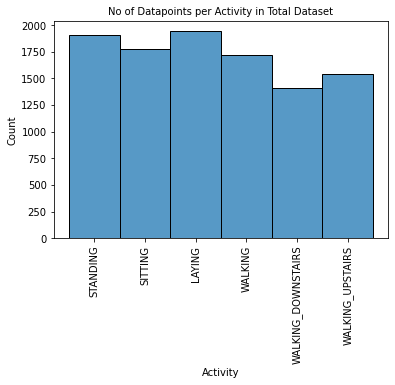

In [34]:
'''
EDA 

No of Datapoints per Activity in Total Dataset

'''

plt.title('No of Datapoints per Activity in Total Dataset', fontsize=10)
sns.histplot(data=train_dataset, x= 'Activity')
#sns.countplot(train_dataset.Activity)
plt.xticks(rotation=90)
plt.show()


/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/pytho

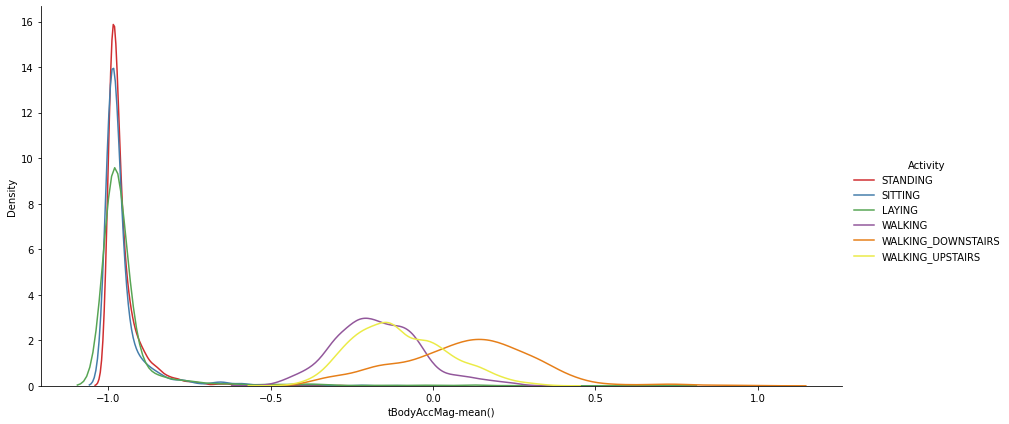

In [35]:
'''
EDA 

To Find the relationship between tBodyAccMag-mean() and Activity 
 

'''

sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(train_dataset, hue='Activity', height=6,aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMag-mean()', hist=False).add_legend()
plt.show()

<ipython-input-36-c35efeaa5874>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['tBodyAccMag-mean()'],color = 'red',hist = False, label = 'WALKING')
<ipython-input-36-c35efeaa5874>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2['tBodyAccMag-mean()'],color = 'blue',

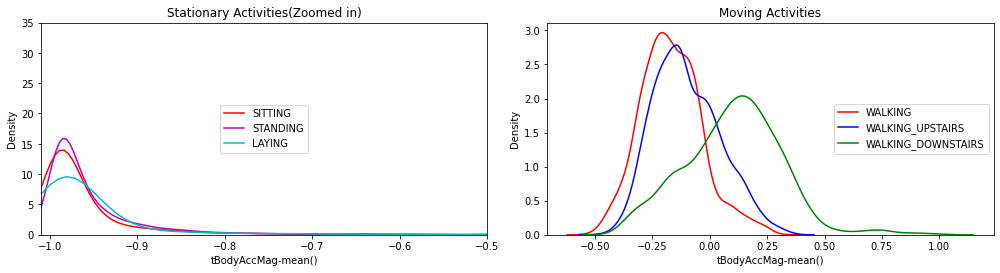

In [36]:
'''
EDA 

To Find the relationship between tBodyAccMag-mean() and Activity 
 

'''

df1 = train_dataset[train_dataset['Activity']=='WALKING']
df2 = train_dataset[train_dataset['Activity']=='WALKING_UPSTAIRS']
df3 = train_dataset[train_dataset['Activity']=='WALKING_DOWNSTAIRS']
df4 = train_dataset[train_dataset['Activity']=='SITTING']
df5 = train_dataset[train_dataset['Activity']=='STANDING']
df6 = train_dataset[train_dataset['Activity']=='LAYING']

plt.figure(figsize=(14,7))
plt.subplot(2,2,2)
plt.title('Moving Activities')
sns.distplot(df1['tBodyAccMag-mean()'],color = 'red',hist = False, label = 'WALKING')
sns.distplot(df2['tBodyAccMag-mean()'],color = 'blue',hist = False,label = 'WALKING_UPSTAIRS')
sns.distplot(df3['tBodyAccMag-mean()'],color = 'green',hist = False, label = 'WALKING_DOWNSTAIRS')
plt.legend(loc='center right')

plt.subplot(2,2,1)
plt.title('Stationary Activities(Zoomed in)')
sns.distplot(df4['tBodyAccMag-mean()'],color = 'r',hist = False, label = 'SITTING')
sns.distplot(df5['tBodyAccMag-mean()'],color = 'm',hist = False,label = 'STANDING')
sns.distplot(df6['tBodyAccMag-mean()'],color = 'c',hist = False, label = 'LAYING')
plt.axis([-1.01, -0.5, 0, 35])
plt.legend(loc='center')

plt.tight_layout()
plt.show()

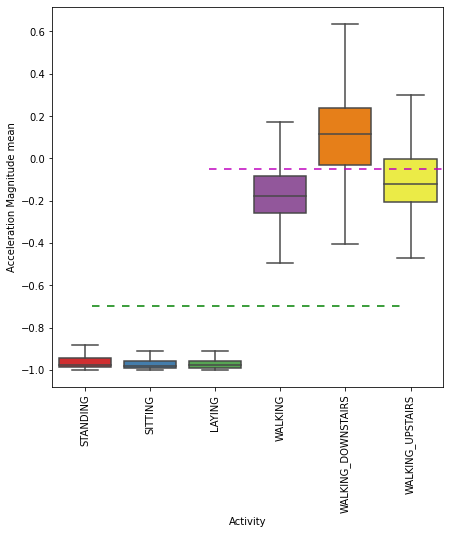

In [37]:
'''
EDA 

To Find the relationship between tBodyAccMag-mean() and Activity 
 

'''

plt.figure(figsize=(7,7))
sns.boxplot(x='Activity', y='tBodyAccMag-mean()',data=train_dataset, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.show()

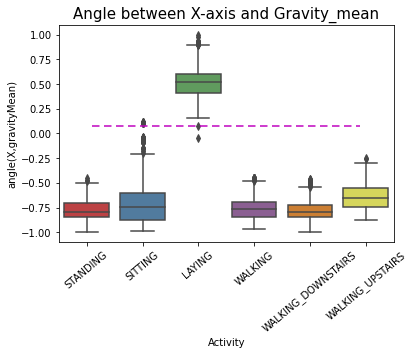

In [38]:
'''
EDA 

To Find the relationship between angle(X,gravityMean) and Activity 
 

'''

sns.boxplot(x='Activity', y='angle(X,gravityMean)', data=train_dataset)
plt.axhline(y=0.08, xmin=0.1, xmax=0.9,c='m',dashes=(5,3))
plt.title('Angle between X-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.show()

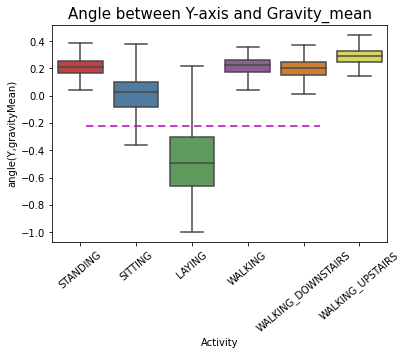

In [39]:
'''
EDA 

To Find the relationship between angle(Y,gravityMean) and Activity 
 

'''
sns.boxplot(x='Activity', y='angle(Y,gravityMean)', data = train_dataset, showfliers=False)
plt.title('Angle between Y-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.axhline(y=-0.22, xmin=0.1, xmax=0.8, dashes=(5,3), c='m')
plt.show()

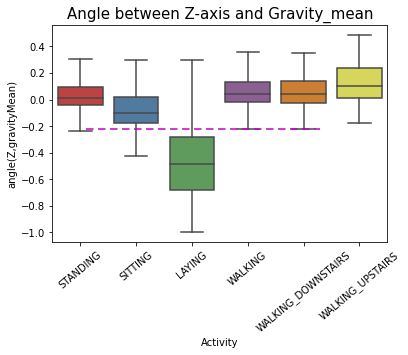

In [40]:
'''
EDA 

To Find the relationship between angle(Z,gravityMean) and Activity 
 

'''
sns.boxplot(x='Activity', y='angle(Z,gravityMean)', data = train_dataset, showfliers=False)
plt.title('Angle between Z-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.axhline(y=-0.22, xmin=0.1, xmax=0.8, dashes=(5,3), c='m')
plt.show()

In [41]:
'''
Load Inertial Data 
Signals will be used for the Data Model Processing 

'''
X_train, Y_train, X_val, Y_val = load_data()

In [42]:
'''
Printing the Details and Shape of the Input features and Output Labels

'''
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(7352, 128, 9)
(2947, 128, 9)
(7352, 6)
(2947, 6)


In [43]:
'''
Deriving Steps, Dimensions and Class details

'''
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = count_classes(Y_train)
n = 128
print(timesteps)
print(input_dim)
print(n_classes)

128
9
6


### **Model - Architecture**

In [44]:
'''
DL Model Design and Architecture

'''
model = Sequential()
model.add(layers.Conv1D(filters=500, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9), name="CONV_1"))
model.add(layers.Conv1D(filters=100, kernel_size=3, activation='relu',kernel_initializer='he_uniform', name="CONV_2"))
model.add(Dropout(0.1))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.LSTM(int(n), activation="tanh", recurrent_activation='sigmoid', return_sequences=True,name="LSTM1"))
model.add(layers.LSTM(int(n/4), activation="tanh", recurrent_activation='sigmoid', return_sequences=True, name="LSTM2"))
model.add(layers.LSTM(int(n/8), activation="tanh", recurrent_activation='sigmoid', name="LSTM3"))
model.add(Dropout(0.3))
model.add(layers.Dense(772, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV_1 (Conv1D)             (None, 126, 500)          14000     
                                                                 
 CONV_2 (Conv1D)             (None, 124, 100)          150100    
                                                                 
 dropout (Dropout)           (None, 124, 100)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 62, 100)          0         
 )                                                               
                                                                 
 LSTM1 (LSTM)                (None, 62, 128)           117248    
                                                                 
 LSTM2 (LSTM)                (None, 62, 32)            20608     
                                                        

### **Model Execution - 1**

loss='categorical_crossentropy'

optimizer='adam'

In [45]:
'''
Model Execution - 1

'''
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model_history = model.fit(X_train,Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
184/184 [==============================] - 19s 29ms/step - loss: 0.5922 - acc: 0.7665 - precision: 0.8693 - recall: 0.6433 - val_loss: 0.2902 - val_acc: 0.9096 - val_precision: 0.9102 - val_recall: 0.9096
Epoch 2/50
184/184 [==============================] - 3s 17ms/step - loss: 0.2441 - acc: 0.9170 - precision: 0.9188 - recall: 0.9123 - val_loss: 0.5394 - val_acc: 0.7267 - val_precision: 0.7268 - val_recall: 0.7254
Epoch 3/50
184/184 [==============================] - 3s 15ms/step - loss: 0.1681 - acc: 0.9366 - precision: 0.9374 - recall: 0.9352 - val_loss: 0.2614 - val_acc: 0.9266 - val_precision: 0.9265 - val_recall: 0.9259
Epoch 4/50
184/184 [==============================] - 3s 15ms/step - loss: 0.1401 - acc: 0.9452 - precision: 0.9469 - recall: 0.9437 - val_loss: 0.3746 - val_acc: 0.8994 - val_precision: 0.8993 - val_recall: 0.8987
Epoch 5/50
184/184 [==============================] - 3s 15ms/step - loss: 0.1391 - acc: 0.9527 - precision: 0.9532 - recall: 0.9520 - val_

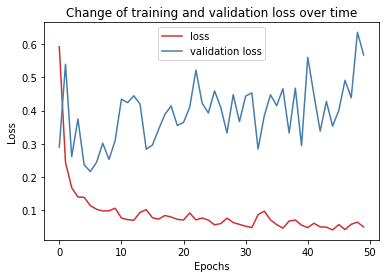

In [46]:
'''
Change of training and validation loss over time
'''
plt.plot(model_history.history["loss"], label = "loss")
plt.plot(model_history.history["val_loss"], label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Change of training and validation loss over time")
plt.show()

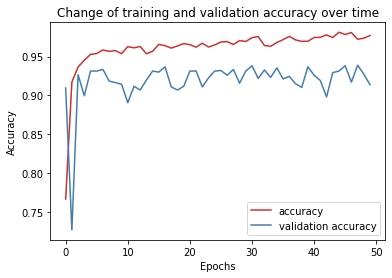

In [47]:
'''
Change of training and validation accuracy over time
'''
plt.plot(model_history.history["acc"], label = "accuracy")
plt.plot(model_history.history["val_acc"], label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Change of training and validation accuracy over time")
plt.show()

In [48]:
'''
Scores Calculation
'''

scores = model.evaluate(X_val, Y_val)

for i, m in enumerate(model.metrics_names):
    print("\n%s: %.3f"% (m, scores[i]))

93/93 [==============================] - 1s 11ms/step - loss: 0.4964 - acc: 0.9253 - precision: 0.9259 - recall: 0.9247

loss: 0.496

acc: 0.925

precision: 0.926

recall: 0.925


### **Model Execution - 2**
loss='categorical_crossentropy'

optimizer='Adadelta'

In [49]:
'''
Model Execution - 2

'''
tf.keras.backend.clear_session()
model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model_history = model.fit(X_train,Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
184/184 [==============================] - 11s 26ms/step - loss: 0.0428 - acc: 0.9772 - precision: 0.9775 - recall: 0.9770 - val_loss: 0.5680 - val_acc: 0.9137 - val_precision: 0.9143 - val_recall: 0.9137
Epoch 2/50
184/184 [==============================] - 3s 15ms/step - loss: 0.0431 - acc: 0.9791 - precision: 0.9791 - recall: 0.9789 - val_loss: 0.5682 - val_acc: 0.9143 - val_precision: 0.9143 - val_recall: 0.9143
Epoch 3/50
184/184 [==============================] - 3s 15ms/step - loss: 0.0440 - acc: 0.9786 - precision: 0.9787 - recall: 0.9784 - val_loss: 0.5685 - val_acc: 0.9143 - val_precision: 0.9143 - val_recall: 0.9143
Epoch 4/50
184/184 [==============================] - 3s 15ms/step - loss: 0.0427 - acc: 0.9774 - precision: 0.9775 - recall: 0.9767 - val_loss: 0.5689 - val_acc: 0.9143 - val_precision: 0.9150 - val_recall: 0.9143
Epoch 5/50
184/184 [==============================] - 3s 19ms/step - loss: 0.0428 - acc: 0.9784 - precision: 0.9787 - recall: 0.9781 - val_

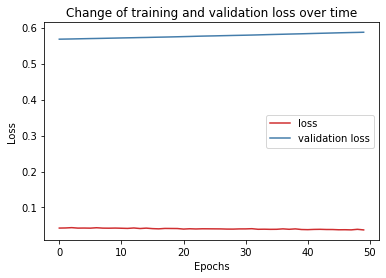

In [50]:
'''
Change of training and validation loss over time
'''
plt.plot(model_history.history["loss"], label = "loss")
plt.plot(model_history.history["val_loss"], label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Change of training and validation loss over time")
plt.show()

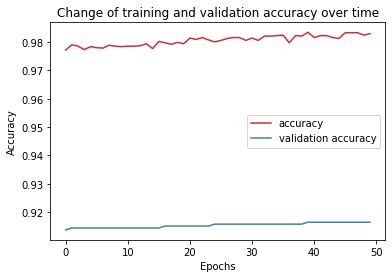

In [51]:
'''
Change of training and validation accuracy over time
'''
plt.plot(model_history.history["acc"], label = "accuracy")
plt.plot(model_history.history["val_acc"], label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Change of training and validation accuracy over time")
plt.show()

In [52]:
'''
Scores Calculation
'''
scores = model.evaluate(X_val, Y_val)

for i, m in enumerate(model.metrics_names):
    print("\n%s: %.3f"% (m, scores[i]))

93/93 [==============================] - 1s 7ms/step - loss: 0.5167 - acc: 0.9257 - precision: 0.9262 - recall: 0.9247

loss: 0.517

acc: 0.926

precision: 0.926

recall: 0.925


### **Model Execution - 3**
loss='categorical_crossentropy'

optimizer='SGD'

In [53]:
'''
Model Execution - 3

'''
tf.keras.backend.clear_session()
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model_history = model.fit(X_train,Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
184/184 [==============================] - 9s 21ms/step - loss: 0.0381 - acc: 0.9830 - precision: 0.9830 - recall: 0.9830 - val_loss: 0.5933 - val_acc: 0.9177 - val_precision: 0.9177 - val_recall: 0.9177
Epoch 2/50
184/184 [==============================] - 3s 17ms/step - loss: 0.0373 - acc: 0.9837 - precision: 0.9838 - recall: 0.9833 - val_loss: 0.6108 - val_acc: 0.9137 - val_precision: 0.9137 - val_recall: 0.9137
Epoch 3/50
184/184 [==============================] - 3s 15ms/step - loss: 0.0341 - acc: 0.9850 - precision: 0.9850 - recall: 0.9850 - val_loss: 0.6219 - val_acc: 0.9123 - val_precision: 0.9129 - val_recall: 0.9123
Epoch 4/50
184/184 [==============================] - 3s 15ms/step - loss: 0.0319 - acc: 0.9847 - precision: 0.9847 - recall: 0.9847 - val_loss: 0.6314 - val_acc: 0.9130 - val_precision: 0.9130 - val_recall: 0.9130
Epoch 5/50
184/184 [==============================] - 3s 15ms/step - loss: 0.0308 - acc: 0.9859 - precision: 0.9862 - recall: 0.9857 - val_l

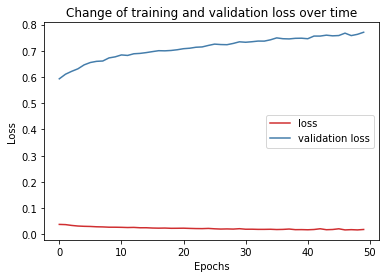

In [54]:
'''
Change of training and validation loss over time
'''
plt.plot(model_history.history["loss"], label = "loss")
plt.plot(model_history.history["val_loss"], label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Change of training and validation loss over time")
plt.show()

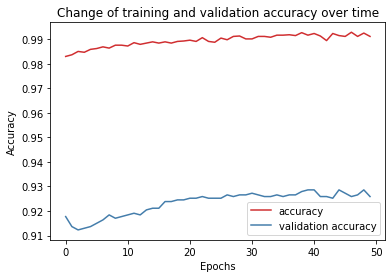

In [55]:
'''
Change of training and validation accuracy over time
'''
plt.plot(model_history.history["acc"], label = "accuracy")
plt.plot(model_history.history["val_acc"], label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Change of training and validation accuracy over time")
plt.show()

In [56]:
'''
Scores Calculation
'''
scores = model.evaluate(X_val, Y_val)

for i, m in enumerate(model.metrics_names):
    print("\n%s: %.3f"% (m, scores[i]))

93/93 [==============================] - 1s 7ms/step - loss: 0.6947 - acc: 0.9141 - precision: 0.9144 - recall: 0.9138

loss: 0.695

acc: 0.914

precision: 0.914

recall: 0.914


### **Model Execution - 4**
loss='categorical_crossentropy'

optimizer='RMSprop'

In [57]:
'''
Model Execution - 4

'''
tf.keras.backend.clear_session()
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model_history = model.fit(X_train,Y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
184/184 [==============================] - 11s 23ms/step - loss: 0.0389 - acc: 0.9861 - precision: 0.9861 - recall: 0.9861 - val_loss: 0.6105 - val_acc: 0.9273 - val_precision: 0.9273 - val_recall: 0.9273
Epoch 2/50
184/184 [==============================] - 3s 15ms/step - loss: 0.0309 - acc: 0.9857 - precision: 0.9859 - recall: 0.9855 - val_loss: 0.5565 - val_acc: 0.9327 - val_precision: 0.9327 - val_recall: 0.9327
Epoch 3/50
184/184 [==============================] - 3s 18ms/step - loss: 0.0292 - acc: 0.9867 - precision: 0.9867 - recall: 0.9867 - val_loss: 0.7202 - val_acc: 0.9225 - val_precision: 0.9225 - val_recall: 0.9225
Epoch 4/50
184/184 [==============================] - 3s 15ms/step - loss: 0.0301 - acc: 0.9864 - precision: 0.9864 - recall: 0.9864 - val_loss: 0.6356 - val_acc: 0.9232 - val_precision: 0.9232 - val_recall: 0.9232
Epoch 5/50
184/184 [==============================] - 3s 15ms/step - loss: 0.0342 - acc: 0.9864 - precision: 0.9864 - recall: 0.9864 - val_

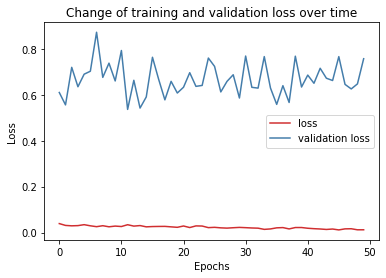

In [58]:
'''
Change of training and validation loss over time
'''
plt.plot(model_history.history["loss"], label = "loss")
plt.plot(model_history.history["val_loss"], label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Change of training and validation loss over time")
plt.show()

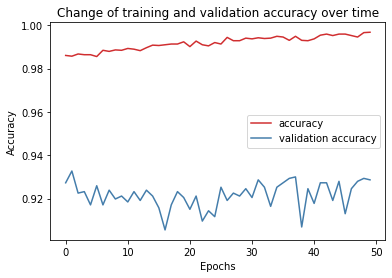

In [59]:
'''
Change of training and validation accuracy over time
'''
plt.plot(model_history.history["acc"], label = "accuracy")
plt.plot(model_history.history["val_acc"], label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Change of training and validation accuracy over time")
plt.show()

In [60]:
'''
Scores Calculation
'''
scores = model.evaluate(X_val, Y_val)

for i, m in enumerate(model.metrics_names):
    print("\n%s: %.3f"% (m, scores[i]))

93/93 [==============================] - 1s 7ms/step - loss: 0.7995 - acc: 0.9206 - precision: 0.9206 - recall: 0.9206

loss: 0.800

acc: 0.921

precision: 0.921

recall: 0.921




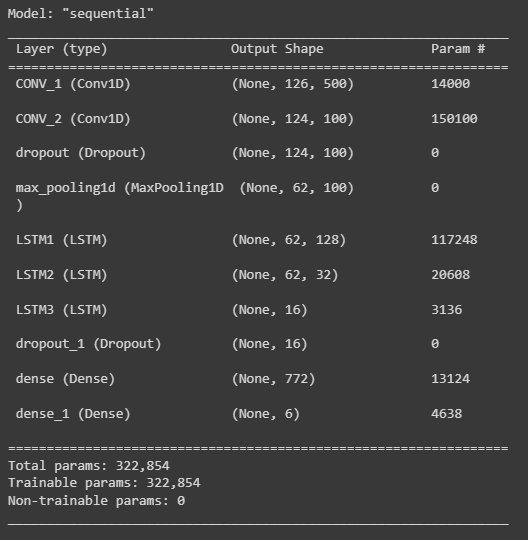



<B>ReLU</B> works significantly better than sigmoid function as an activation function

<B>ReLU</B> network trains faster and reaches better accuracy

<B>Adam</B> is default optimizer

<B>Adam</B> is generally better than other optimization algorithms

<B>Adam</B> generally have faster computation time

<B>Adam</B> require fewer parameters for tuning

<B>Multiclass classification</B> : Need to encode the target labels and transform them in a categorical form. The output variable contains Seven different string values.

When modeling multi-class classification problems using neural networks, it is good practice to reshape the output attribute from a vector that contains values for each class value to a matrix with a Boolean for each class value and whether a given instance has that class value or not.

This is called <B>one-hot encoding</B> or creating dummy variables from a categorical variable.

### **Model Execution - 1**

## loss='categorical_crossentropy'

## optimizer='adam'


The <B>DL Model with ADAM as optimizer</B> seems to be best fit model as compared to others

The Model is not underfitting

The Model is not overfitting

The features selected are optimal to predict the class of the Beans 

The model is not complex

The model is not very resource intensive

The model is not very large/heavy

The model performance is good

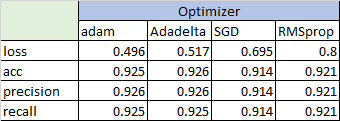